# Portfolio assignment week 7
#### Author: Karina Diaz

## 1. Bagging vs Boosting
The scikit-learn library provides several options for bagging and boosting. It is possible to create your own boosting model based on a base model. For instance, you can create a tree based bagging model. In addition, scikit-learn provides AdaBoost. For XGBoost it is best to use the xgboost library.

Based on the theory in the [accompanying notebook](https://github.com/fenna/BFVM23DATASCNC5/blob/main/Exercises/E_BAGGING_BOOSTING.ipynb), create a bagging, boosting and dummy classifier. Test these classifiers on the [breast cancer dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset). Go through the data science pipeline as you've done before:

1. Try to understand the dataset globally.
2. Load the data.
3. Exploratory analysis
4. Preprocess data (skewness, normality, etc.)
5. Modeling (cross-validation and training). (Create several bagging classifiers with different estimators.)
6. Evaluation (Use the evaluation methods as described in the previous lessons. Then compare the different models.)
7. Try to understand why some methods perform better than others. Try different configurations for your bagging and boosting models.



In [22]:
# Libraries needed

# Loading and preprocessing the data
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import normaltest
from sklearn.model_selection import train_test_split

# Creating a pipeline 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Sklearn models
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_curve, RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score


### Loading the data

In [23]:
# Defining a function to get the config file
def get_config():
    '''Setting the config file'''
    with open("config_DS3.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config


In [24]:
config = get_config()
cancer_path = (config['breast_cancer'])
cancer_path

# Creating a data frame with the data
cancer_df = pd.read_csv(cancer_path)
cancer_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### Exploratory analysis

#### Highlights 

* The data consist of **569 observations** and **32** columns or **features**.
* Samples:  
     - **[B]enign**: 357  
     - **[M]alignat**: 212
* The data types are correct.
* A non informative column is dropped.
* There is no missing data.
* `diagnosis` was converted into numercical values for a better classification. **M == 1**,  **B == 0**
* The raw data is not normalised

In [25]:
print('Data shape: ', cancer_df.shape)
print(cancer_df.info())

Data shape:  (569, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  per

In [26]:
cancer_df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [27]:
# Checking how the data is divided
print(cancer_df['diagnosis'].value_counts())

B    357
M    212
Name: diagnosis, dtype: int64


In [28]:
# drop the not needed column, in this case is the Id one 
cancer_df.drop('id', axis=1, inplace = True)

In [29]:
# convert the diagnosis columns into numerical values rather than strings
# convert the M (malignat) to 1 and B (benign) to 0
cancer_df.replace({'M': 1, 'B': 0}, inplace=True)
print(cancer_df['diagnosis'].value_counts())


0    357
1    212
Name: diagnosis, dtype: int64


In [30]:
#check for missing data
missing = cancer_df.isnull().sum()
print('-> Missing data in:', missing[missing > 0])
# There is no missing data
print('-'*50)

# Check which columns are present on the dataframe
print('Features:', cancer_df.columns)

-> Missing data in: Series([], dtype: int64)
--------------------------------------------------
Features: Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')


### Preprocess data

In [31]:
# Checking for skewness. I kept the columns that have a skew above .75 
skew_columns = (cancer_df.skew(numeric_only=True).sort_values(ascending=False))

skew_columns = skew_columns.loc[skew_columns > 0.75]
skew_columns

area_se                    5.447186
concavity_se               5.110463
fractal_dimension_se       3.923969
perimeter_se               3.443615
radius_se                  3.088612
smoothness_se              2.314450
symmetry_se                2.195133
compactness_se             1.902221
area_worst                 1.859373
fractal_dimension_worst    1.662579
texture_se                 1.646444
area_mean                  1.645732
compactness_worst          1.473555
concave points_se          1.444678
symmetry_worst             1.433928
concavity_mean             1.401180
fractal_dimension_mean     1.304489
compactness_mean           1.190123
concave points_mean        1.171180
concavity_worst            1.150237
perimeter_worst            1.128164
radius_worst               1.103115
perimeter_mean             0.990650
radius_mean                0.942380
dtype: float64

In [32]:
# Performing log transform on skew columns
for col in skew_columns.index.tolist():
    cancer_df[col] = np.log1p(cancer_df[col])

Testing for normality

* Null hypothesis = that the data was drawn from a normal distribution.
* Alternative hypothesis = the data was not drawn from a normal distribution.


In [33]:
res, pvalue = normaltest(cancer_df.select_dtypes(include=np.number))
print(pvalue < 0.05)
print('Number of samples with p val <0.05:', (pvalue < 0.05).sum())

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
Number of samples with p val <0.05: 31


All the p-values are “small” (<0.05).  

The alternative hypothesis is accepted: **the weights were not drawn from a normal distribution**. Therefore, the data needs to be scaled. I will perfom this in the following steps, when fitting the model.

In [34]:
# Creating the high dimensional feature space X needed for the modeling part
# I remove the diagnosis column
X = cancer_df.iloc[:, 1:]
X.head(3)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,2.943913,10.38,4.818667,6.909753,0.11840,0.244983,0.262441,0.137237,0.2419,0.075766,...,3.272606,17.33,5.223594,7.610853,0.1622,0.510185,0.537604,0.2654,0.378505,0.112346
1,3.071303,17.77,4.897093,7.190676,0.08474,0.075701,0.083330,0.067818,0.1812,0.055122,...,3.257712,23.41,5.073923,7.579168,0.1238,0.171092,0.216401,0.1860,0.242946,0.085278
2,3.029650,21.25,4.875197,7.093405,0.10960,0.148334,0.180153,0.120357,0.2069,0.058259,...,3.201526,25.53,5.033701,7.444249,0.1444,0.353821,0.371839,0.2430,0.308440,0.083955


In [35]:
# creating a vector with the tags of the disease
data_labels = cancer_df['diagnosis'].values
print(data_labels[:40])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1]


In [36]:
# Splitting the data into training set and test set
# 80% training and 20% test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    data_labels,
                                                    test_size=0.2)

print(X_train.shape, X_test.shape,
      y_train.shape, y_test.shape)

(455, 30) (114, 30) (455,) (114,)


### **Modeling & evaluation**

##### 0. Defining the functions needed for the modeling and evaluation

In [37]:
def evaluation_results(y_test, y_pred, y_score):
    '''Function to perform the different evaluation test of the classifiers 
    analysed
    Arguments 
        y_test: test data set (20% of the original data). Contains the 
        labels of the cancer status.
        y_pred: Predicted labels after training the model
        y_score: Predicted confidence scores for samples predicted
    Returns
        Classifiaction report, Roc auc score (AUC) and Mean average precision 
        score (mAP). As well as the plots of the confusion Matrix, 
        ROC-AUC curve and Precision-Recall Curve'''
    
    #M (malignat) to 1 and B (benign) to 0
    target_names = ['Bening', 'Malignant']

    #1.- Classifiaction report 
    print('Classification report - Test data')
    print(classification_report(y_test, y_pred,target_names=target_names))

    # 2.- Confussion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=target_names)

    #3.- Roc auc 
    # pos label: {negative, positive} --> {0,1}
    # I am more interested in the persons that were predicted to have cancer 
    # rather than the ones that were predicted as benign. So positive label is 1.
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    # Calculate the AUC
    roc_auc = auc(fpr, tpr)

    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='SVC')

    #4.- Precision recall curve
    prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1)
    ap = average_precision_score(y_test, y_score)
    pre_display = PrecisionRecallDisplay(precision=prec, recall=recall,
                                        average_precision=ap,
                                        estimator_name="LinearSVC")


    print(f'Roc auc score (AUC): {roc_auc}') 
    print(f'Mean average precision score (mAP): {ap}')


    ## plotting the results
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Model Evaluation')
    cm_display.plot(ax=ax1)
    ax1.set_title('Confusion Matrix')
    roc_display.plot(ax=ax2)
    ax2.set_title('ROC Curve')
    pre_display.plot(ax=ax3)
    ax3.set_title('Precision-Recall Curve')
    plt.show()

### Bagging

Bagging stands for bootstrap aggregating and consists of training several models in parallel with replacement. So in the next models I perform bagging modeling with `bootstrap= True`.  
The following code set the classifiers that are going yo be trained by an ensemble of 50 classifiers randomly sampled from the training set with replacement.

In [38]:
# Giving names to the models
names = ["Linear SCV",
         "DecisionTreeClassifier",
         "Nearest Neighbors",
         "Random Forest",
         "Bernoulli Naive Bayes smoothing",
         "Gaussian Naive Bayes",
         "Logistic Regression"
         ]


# Models that are going to be tested 
classifiers = [BaggingClassifier(SVC(kernel="linear"),n_estimators=50,
                                 bootstrap=True, random_state=0),
               BaggingClassifier(DecisionTreeClassifier(max_depth=5), 
                                 n_estimators=50, bootstrap=True, random_state=0),
               BaggingClassifier(KNeighborsClassifier(3), n_estimators=50,
                                  bootstrap=True, random_state=0),
               BaggingClassifier(RandomForestClassifier(max_depth=5),
                                  n_estimators=50, bootstrap=True, random_state=0),
               BaggingClassifier(BernoulliNB(alpha=1), n_estimators=50,
                                 bootstrap=True, random_state=0),
               BaggingClassifier(GaussianNB(), n_estimators=50, bootstrap=True, 
                                 random_state=0),
               BaggingClassifier(LogisticRegression(), n_estimators=50, 
                                 bootstrap=True, random_state=0)]

Linear SCV
Accuracy score: 0.9824561403508771
Classification report - Test data
              precision    recall  f1-score   support

      Bening       1.00      0.97      0.98        67
   Malignant       0.96      1.00      0.98        47

    accuracy                           0.98       114
   macro avg       0.98      0.99      0.98       114
weighted avg       0.98      0.98      0.98       114

Roc auc score (AUC): 1.0
Mean average precision score (mAP): 1.0


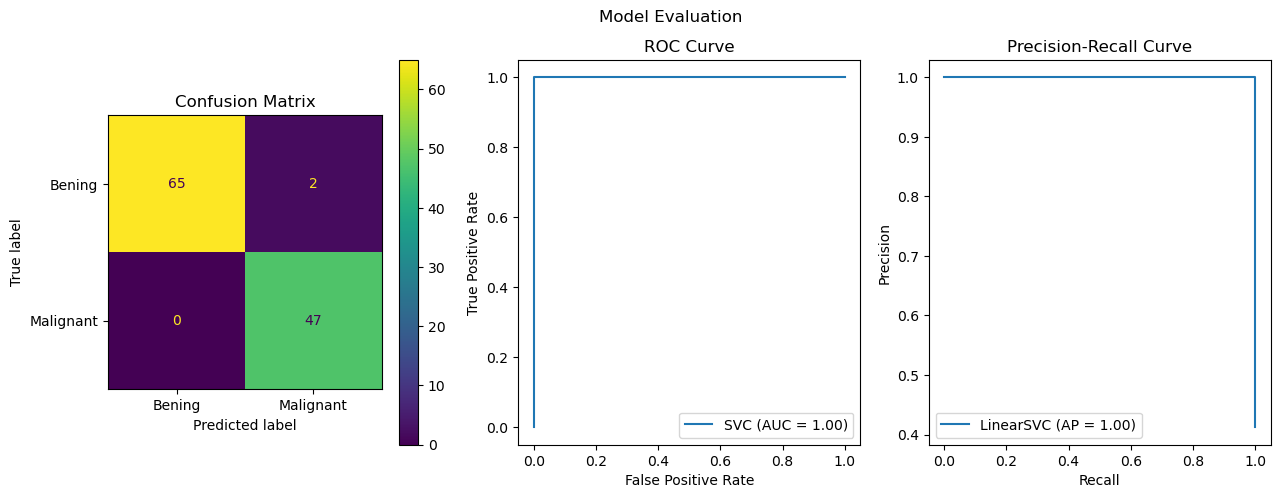

DecisionTreeClassifier
Accuracy score: 0.9473684210526315
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.93      0.95        67
   Malignant       0.90      0.98      0.94        47

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114

Roc auc score (AUC): 0.9961892664337885
Mean average precision score (mAP): 0.9950772604241614


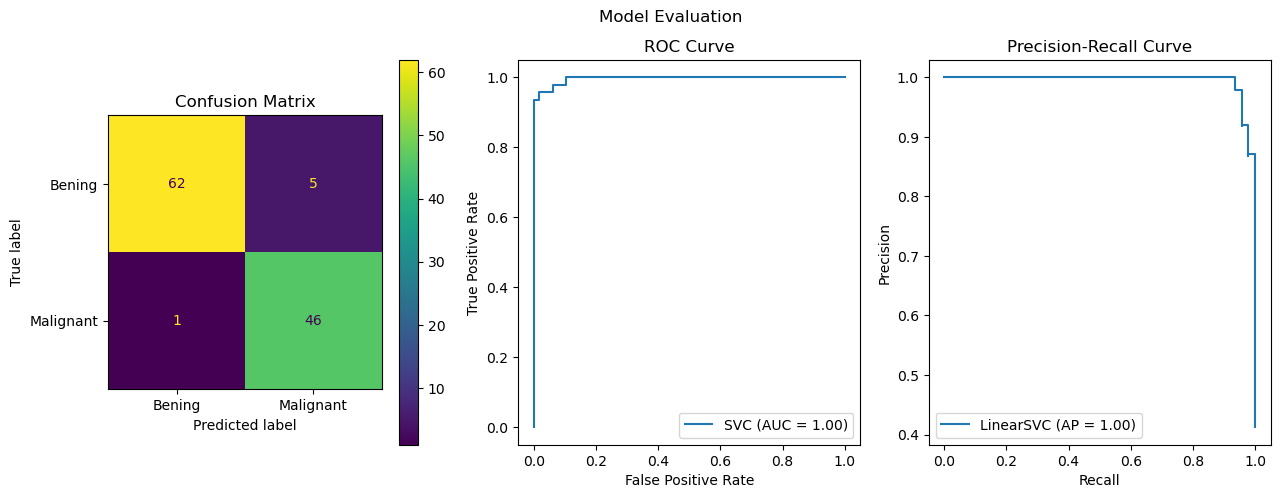

Nearest Neighbors
Accuracy score: 0.9736842105263158
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.97      0.98        67
   Malignant       0.96      0.98      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Roc auc score (AUC): 0.9969831692600826
Mean average precision score (mAP): 0.996267263904442


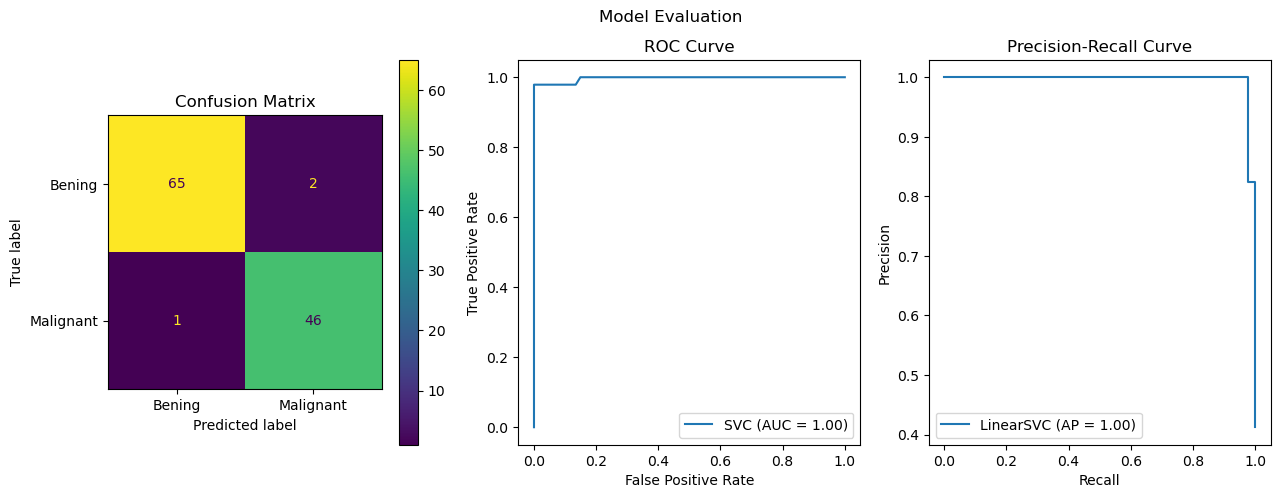

Random Forest
Accuracy score: 0.9649122807017544
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.97      0.97      0.97        67
   Malignant       0.96      0.96      0.96        47

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

Roc auc score (AUC): 0.9952365830422356
Mean average precision score (mAP): 0.9940592281324148


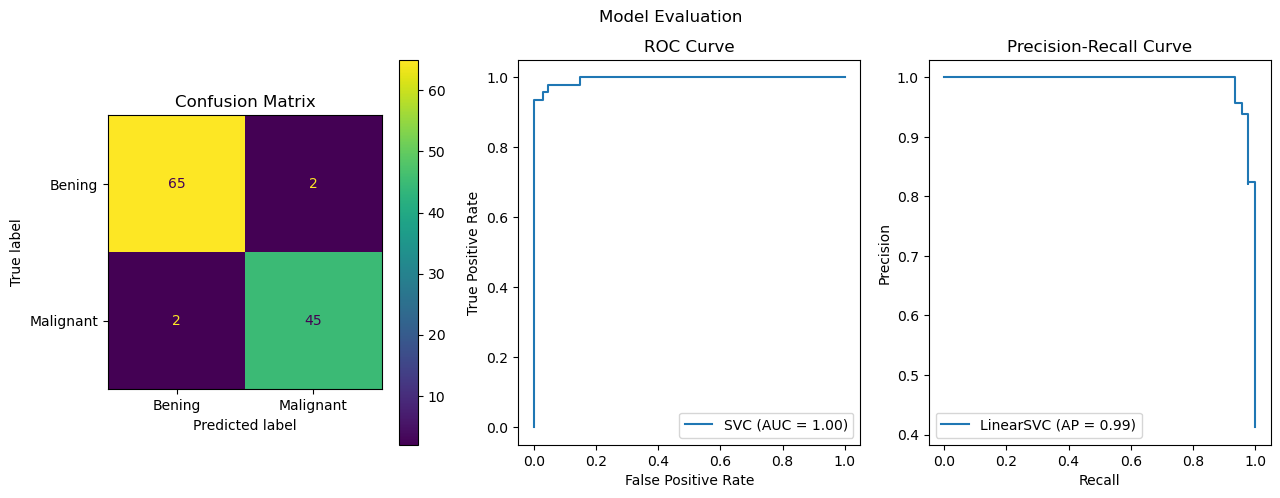

Bernoulli Naive Bayes smoothing
Accuracy score: 0.8947368421052632
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.95      0.87      0.91        67
   Malignant       0.83      0.94      0.88        47

    accuracy                           0.89       114
   macro avg       0.89      0.90      0.89       114
weighted avg       0.90      0.89      0.90       114

Roc auc score (AUC): 0.9863448713877422
Mean average precision score (mAP): 0.9835731748741202


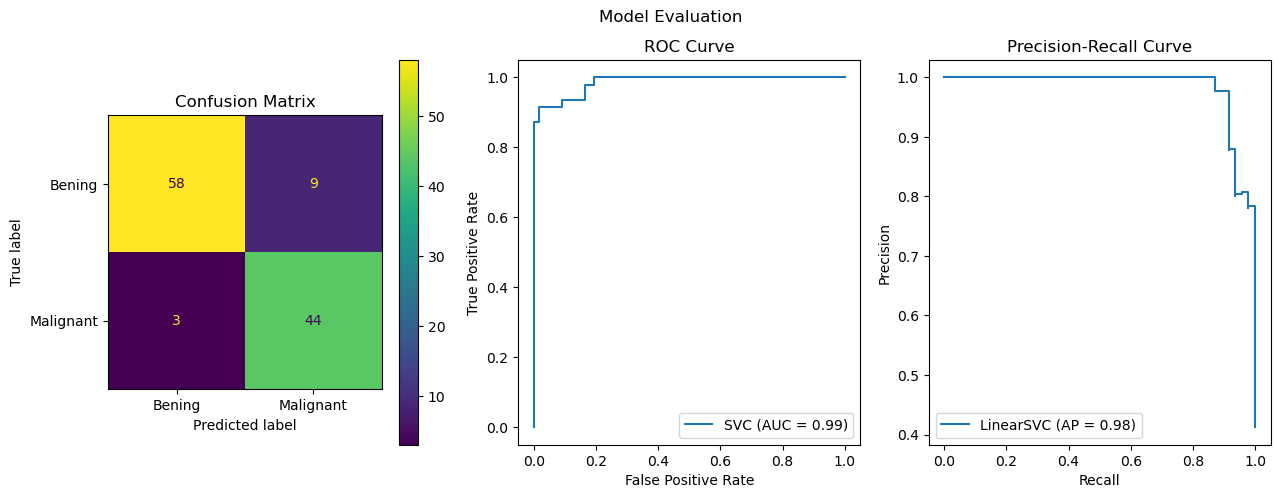

Gaussian Naive Bayes
Accuracy score: 0.9473684210526315
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.97      0.94      0.95        67
   Malignant       0.92      0.96      0.94        47

    accuracy                           0.95       114
   macro avg       0.94      0.95      0.95       114
weighted avg       0.95      0.95      0.95       114

Roc auc score (AUC): 0.9911082883455066
Mean average precision score (mAP): 0.9898410397553047


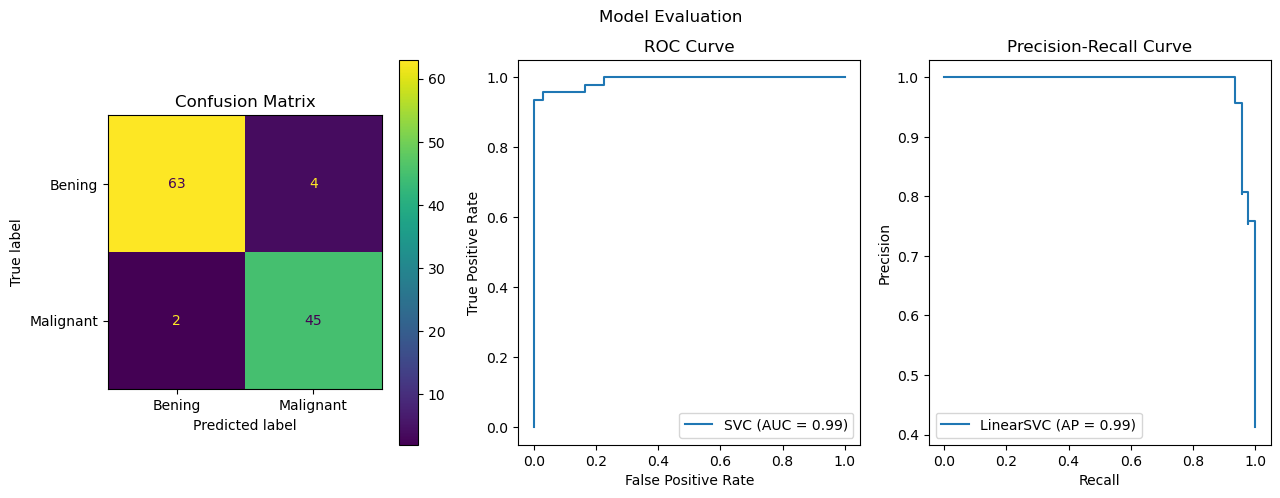

Logistic Regression
Accuracy score: 0.9912280701754386
Classification report - Test data
              precision    recall  f1-score   support

      Bening       1.00      0.99      0.99        67
   Malignant       0.98      1.00      0.99        47

    accuracy                           0.99       114
   macro avg       0.99      0.99      0.99       114
weighted avg       0.99      0.99      0.99       114

Roc auc score (AUC): 0.9996824388694824
Mean average precision score (mAP): 0.9995567375886525


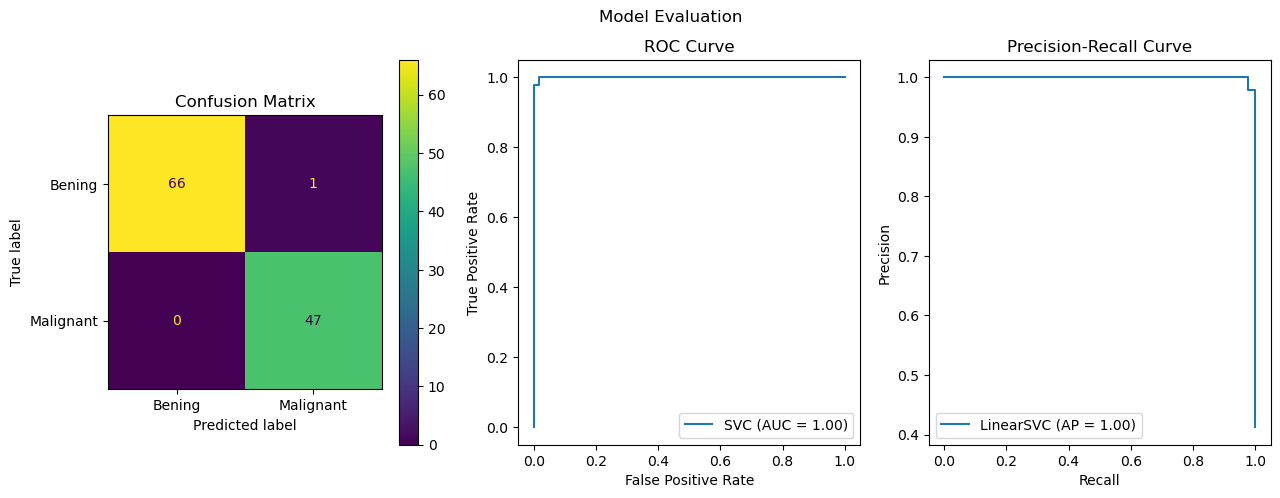

In [39]:
# Loop to apply the different models defined on the 'classifiers' variable, as 
# well as plotting the evaution metrics of the modeling. 

for name, clf in zip(names, classifiers):

    # make pipeline to scale and fit the datasets
    clf = Pipeline([('scaler', StandardScaler()),('classifier',clf)])
    clf.fit(X_train, y_train)

    # Predict the labels for X test dataset
    y_pred = clf.predict(X_test)

    # getting the accuracy score
    score = accuracy_score(y_test, y_pred)

    # # Predict class probabilities of the positive class in the input X
    y_score = clf.predict_proba(X_test)[:, 1]

    # Printing model name and accuracy score
    print(name) 
    print('Accuracy score:', score)
    
    # Printing the model evaluation
    evaluation_results(y_test, y_pred, y_score)


### Analysis

In general single models perform well because either they tend to have high bias or to much variance to be robust. The idea of the ensemble models is to combine these single models to produce a strong learner that achieves better performance. These combination of models follows the hypothesis that **when weak models are correctly combined we can obtain more accurate and/or robust models**. By averaging the base models, we obtain a final model with less variance, so a better bias-variance tradeoff is obtained.  
   
In **bagging** in particular, the approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set and the **sampling is performed with replacement**. Generally, the **net result** is that the ensemble has a **similar bias but a lower variance than a single predictor** trained on the original training set.  

----

  
After looking at the bagging results and evaluation metrics I found out that the best models for the cancer data are <span style="color:#8b0000">LinearSVC and LogisticRegression</span>. It curious, because in the 'Week_05.ipynb' nootebook I trained a LogisticRegression model and a linearSVC model, with the cancer data (in between other SVC clasficators) and both models were the ones that perfomed better, being LogisticRegression the best one. In the next table I compare the results of these two models with bagging method and without bagging method.  
  
(Data extracted from Week_05.ipynb and from the classifiers of this notebook)  
  
| Model              |  FP |  FN | Roc- auc         |  mAP              | Model accuracy-score        |f1- score|
| :----------------- | :-: | :-: | :--------------- | :--------------- | :--------------- | :-: |
| LinearSVC          |  1  |  3  |0.9812638932994602|0.9827862994117325|0.9824175824175825|0.96|
| <span style="color:blue">LinearSVC - Bagging</span>        |  2  |<span style="color:#8b0000">0</span>  |<span style="color:#8b0000">1</span>|<span style="color:#8b0000">1</span>|0.9824561403508771|0.98|
| LogisticRegression |  3  |  1 |0.9812638932994602|0.9822609587285313|0.9824175824175825|0.96|
| <span style="color:blue">LogisticRegression - Bagging</span> |  1  |<span style="color:#8b0000">0</span>  |0.9996824388694824|0.9995567375886525|<span style="color:#8b0000">0.9912280701754386</span>|<span style="color:#8b0000">0.99</span>|  
  
*Note: I highlighted the best results in red.*   
  
Comparing the results between bagging and not bagging we can definitely see that the models with a bagging approach performed slightly better than without bagging. We can definitely see that with the bagging approach less False Negatives are obtained which is a really good thing in the cancer data set.  

------

### Boosting

Boosting refers to any ensemble method that can combine several weak learners into a strong learner. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor.  
  
Boosting uses a weight approach. I tried to test the same classfifers tested in the bagging section to compare the results, but *'KNeighborsClassifier doesn't support sample_weight'* so I had to skip this classifer. 

In [40]:
# Giving names to the models
names = ["Linear SCV",
         "DecisionTreeClassifier",
         "Random Forest",
         "Bernoulli Naive Bayes smoothing",
         "Gaussian Naive Bayes",
         "Logistic Regression"]


# Models that are going to be tested 
classifiers = [AdaBoostClassifier(SVC(kernel="linear"),n_estimators=50,
                                  random_state=0, algorithm='SAMME'),
               AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), 
                                  n_estimators=50, random_state=0, algorithm='SAMME'),
               AdaBoostClassifier(RandomForestClassifier(max_depth=5), 
                                  n_estimators=50, random_state=0, algorithm='SAMME'),
               AdaBoostClassifier(BernoulliNB(alpha=1), n_estimators=50, 
                                  random_state=0, algorithm='SAMME'),
               AdaBoostClassifier(GaussianNB(), n_estimators=50, random_state=0,
                                   algorithm='SAMME'),
               AdaBoostClassifier(LogisticRegression(), n_estimators=50, 
                                  random_state=0, algorithm='SAMME')]

Linear SCV
Accuracy score: 0.9736842105263158
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.97      0.98        67
   Malignant       0.96      0.98      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Roc auc score (AUC): 0.9963480469990473
Mean average precision score (mAP): 0.9953900709219858


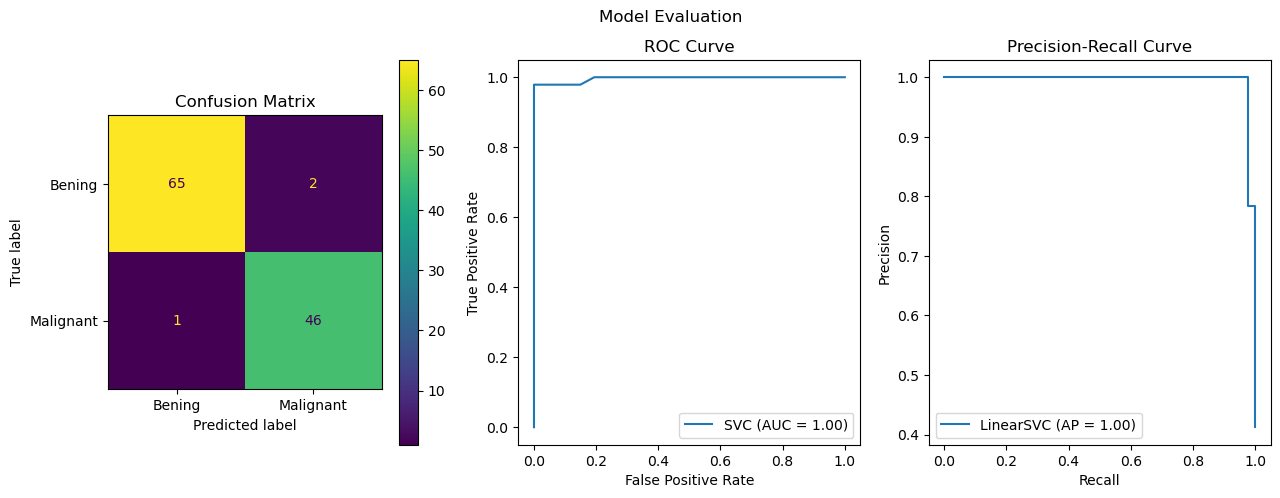

DecisionTreeClassifier
Accuracy score: 0.9649122807017544
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.96      0.97        67
   Malignant       0.94      0.98      0.96        47

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Roc auc score (AUC): 0.9980946332168942
Mean average precision score (mAP): 0.9975014799596058


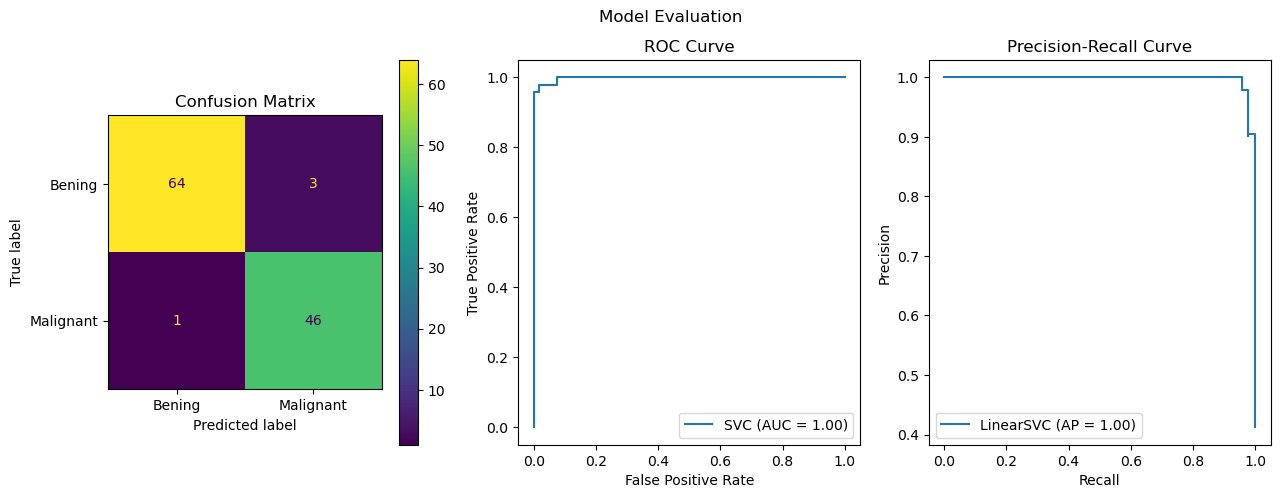

Random Forest
Accuracy score: 0.9649122807017544
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.96      0.97        67
   Malignant       0.94      0.98      0.96        47

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114

Roc auc score (AUC): 0.9877738964750714
Mean average precision score (mAP): 0.9848900366417563


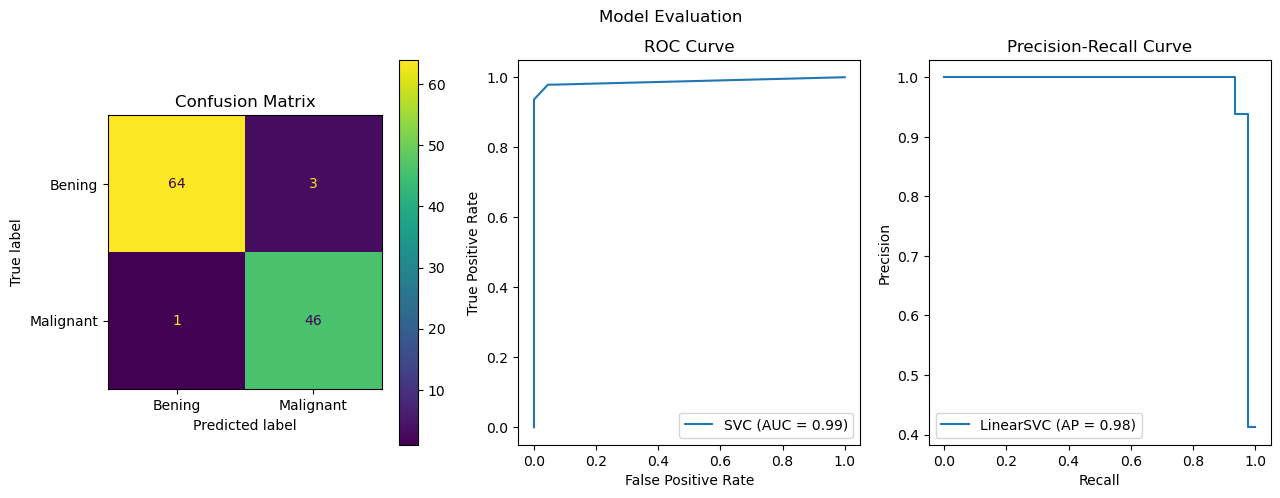

Bernoulli Naive Bayes smoothing
Accuracy score: 0.9122807017543859
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.87      0.92        67
   Malignant       0.84      0.98      0.90        47

    accuracy                           0.91       114
   macro avg       0.91      0.92      0.91       114
weighted avg       0.92      0.91      0.91       114

Roc auc score (AUC): 0.9920609717370594
Mean average precision score (mAP): 0.9891993841121091


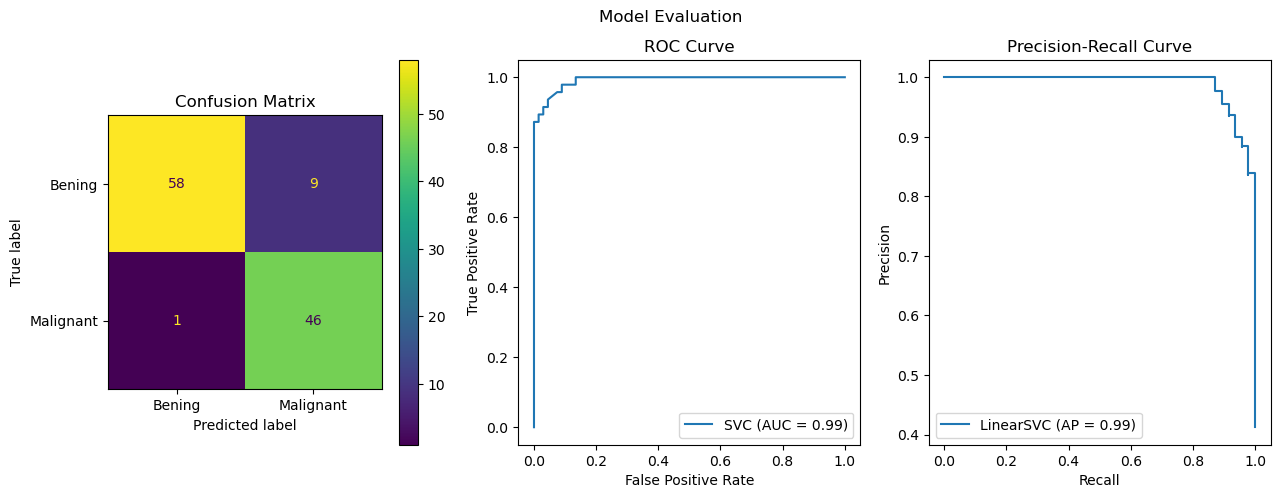

Gaussian Naive Bayes
Accuracy score: 0.9736842105263158
Classification report - Test data
              precision    recall  f1-score   support

      Bening       0.98      0.97      0.98        67
   Malignant       0.96      0.98      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

Roc auc score (AUC): 0.9920609717370594
Mean average precision score (mAP): 0.9916373747326002


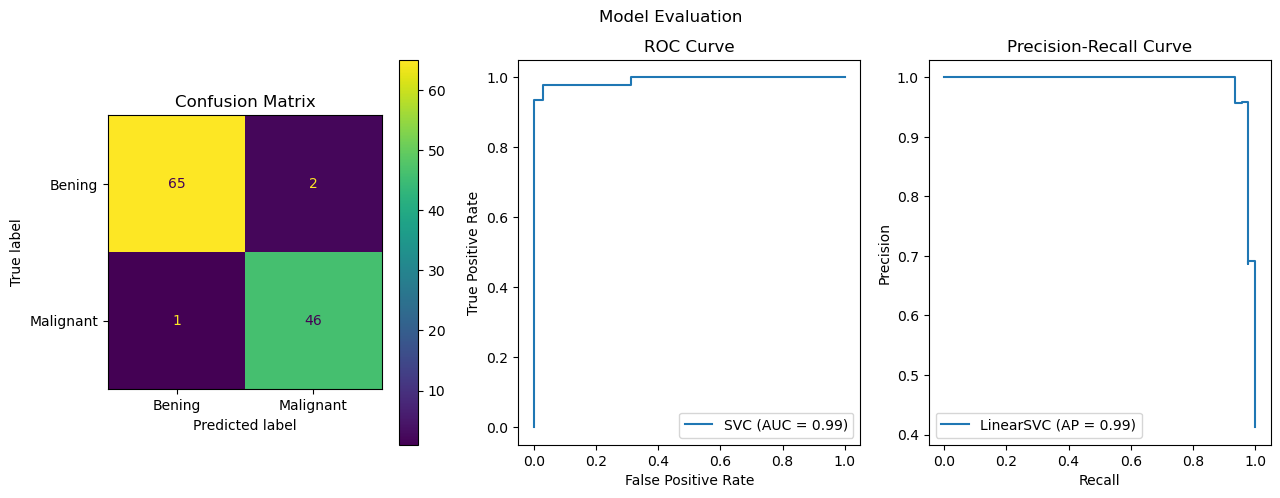

Logistic Regression
Accuracy score: 0.9736842105263158
Classification report - Test data
              precision    recall  f1-score   support

      Bening       1.00      0.96      0.98        67
   Malignant       0.94      1.00      0.97        47

    accuracy                           0.97       114
   macro avg       0.97      0.98      0.97       114
weighted avg       0.98      0.97      0.97       114

Roc auc score (AUC): 1.0
Mean average precision score (mAP): 1.0


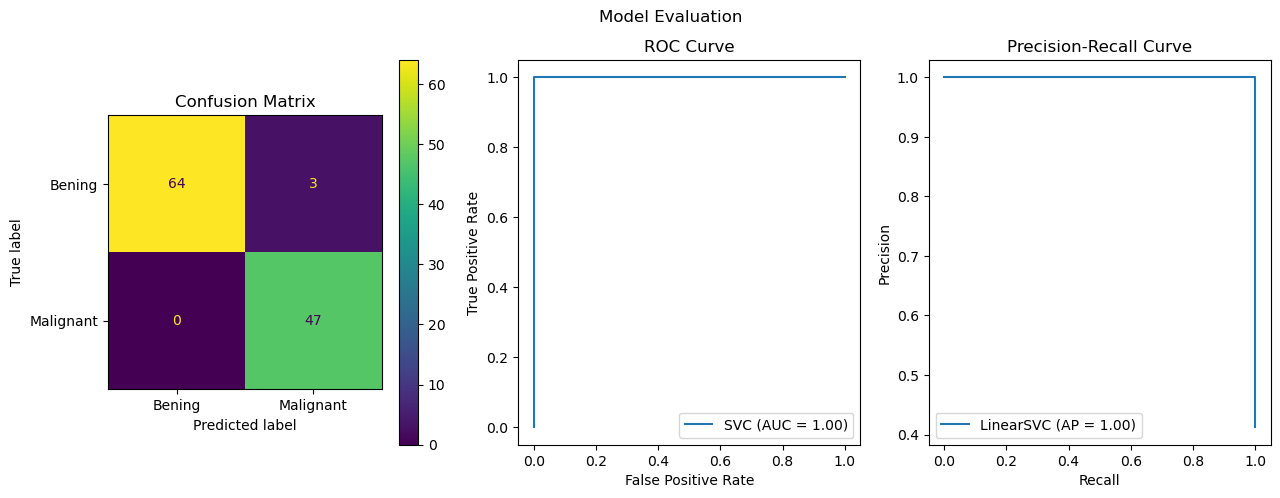

In [41]:
# Loop to apply the different models defined on the 'classifiers' variable, as 
# well as plotting the evaution metrics of the modeling. 

for name, clf in zip(names, classifiers):

    # make pipeline to scale and fit the datasets
    clf = Pipeline([('scaler', StandardScaler()),('classifier',clf)])
    clf.fit(X_train, y_train)

    # Predict the labels for X test dataset
    y_pred = clf.predict(X_test)

    # getting the accuracy score
    score = accuracy_score(y_test, y_pred)

    # # Predict class probabilities of the positive class in the input X
    y_score = clf.predict_proba(X_test)[:, 1]

    # Printing model name and accuracy score
    print(name) 
    print('Accuracy score:', score)
    
    # Printing the model evaluation
    evaluation_results(y_test, y_pred, y_score)

### Analysis

After looking at the boosting results and evaluation metrics I found out that the best models for the cancer data are <span style="color:#8b0000">LinearSVC, LogisticRegression and Gaussian Naive Bayes</span>. It curious, because in the 'Week_05.ipynb' nootebook I trained a LogisticRegression model and a linearSVC model, with the cancer data (in between other SVC clasficators) and both models were the ones that perfomed better, being LogisticRegression the best one. Nevertheless, I did not have a Gaussian model without a Boosting approach to compare both approaches.  
  
In the next table I compare the results of these three models with bagging method and without bagging method (when available).  
  
(Data extracted from Week_05.ipynb and from the classifiers of this notebook).
 
| Model              |  FP |  FN | Roc- auc         |  mAP              | Model accuracy-score        |f1- score|
| :----------------- | :-: | :-: | :--------------- | :--------------- | :--------------- | :-: |
| LinearSVC          |  1  |  3  |0.9812638932994602|0.9827862994117325|<span style="color:#8b0000">0.9824175824175825</span>|0.96|
|<span style="color:green">LinearSVC - Boosting</span>|  2  |  1  |0.9963480469990473|0.9953900709219858|0.9736842105263158|<span style="color:#8b0000">0.97</span>|
| LogisticRegression |  3  |  1 |0.9812638932994602|0.9822609587285313|<span style="color:#8b0000">0.9824175824175825</span>|0.96|
|<span style="color:green">LogisticRegression - Boosting</span>|  3  |<span style="color:#8b0000">0</span> |<span style="color:#8b0000">1.0</span>|<span style="color:#8b0000">1.0</span>|0.9736842105263158|<span style="color:#8b0000">0.97</span>|
|<span style="color:green">Gaussian Naive Bayes - Boosting</span>|  2  |  2 |0.9920609717370594|0.9916373747326002|0.9736842105263158|<span style="color:#8b0000">0.97</span>|

  
*Note: I highlighted the best results in red.*   

In general the the boosting methods give a better results, rather than the models without boosting. The only parameter that is better without boosting is the `Model accuracy-score`, but the difference is not that big in between the these models and the ones with boosting approach.

-----

### Conclusion

The bagging and boosting methods provided better results when classifying the cancer data than when not using these approaches.  
    
In between bagging and boosting there is not a big difference in the results. The next tables compare the different approaches of the best models. I again highlighted in red the best scores. 

The desicion of using one bagging or boosting in the data might depent in the context of the data and the question that needs to be solve, but these two approaches definitely improved the classification.
   

| Model              |  FP |  FN | Roc- auc         |  mAP              | Model accuracy-score        |f1- score|
| :----------------- | :-: | :-: | :--------------- | :--------------- | :--------------- | :-: |
| LinearSVC          |  1  |  3  |0.9812638932994602|0.9827862994117325|0.9824175824175825|0.96|
| <span style="color:blue">LinearSVC - Bagging</span>        |  2  |<span style="color:#8b0000">0</span>|<span style="color:#8b0000">1.0</span>|<span style="color:#8b0000">1.0</span>|<span style="color:#8b0000">0.9824561403508771</span>|<span style="color:#8b0000">0.98</span>|
|<span style="color:green">LinearSVC - Boosting</span>|  2  |  1  |0.9963480469990473|0.9953900709219858|0.9736842105263158|0.97|


| Model              |  FP |  FN | Roc- auc         |  mAP              | Model accuracy-score        |f1- score|
| :----------------- | :-: | :-: | :--------------- | :--------------- | :--------------- | :-: |
| LogisticRegression |  3  |  1 |0.9812638932994602|0.9822609587285313|0.9824175824175825|0.96|
|<span style="color:blue">LogisticRegression - Bagging</span> |  1  |<span style="color:#8b0000">0</span>|0.9996824388694824|0.9995567375886525|<span style="color:#8b0000">0.9912280701754386</span>|<span style="color:#8b0000">0.99</span>|
|<span style="color:green">LogisticRegression - Boosting</span>|  3  |<span style="color:#8b0000">0</span> |<span style="color:#8b0000">1.0</span>|<span style="color:#8b0000">1.0</span>|0.9736842105263158|0.97|

| Model              |  FP |  FN | Roc- auc         |  mAP              | Model accuracy-score        |f1- score|
| :----------------- | :-: | :-: | :--------------- | :--------------- | :--------------- | :-: |
|<span style="color:green">Gaussian Naive Bayes - Boosting</span>|  2  |  2 |0.9920609717370594|0.9916373747326002|<span style="color:#8b0000">0.9736842105263158</span>|<span style="color:#8b0000">0.97</span>|

#### References
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html
* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html 
* https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html 
* *GeÌ ron, A. (2019). Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems (2nd ed.). O'Reilly.*
* https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205 